In [1]:
#导入必要的包
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

# 设置字体为中文字体，例如SimHei或SimSun
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False   # 解决保存图像是负号'-'显示为方块的问题

In [2]:
#设置随机数的种子
torch.manual_seed(123)
np.random.seed(123)
random.seed(123)

#在云服务器上使用以下代码
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = Fales

#读取文件并去除含有空值的行
df = pd.read_csv("../temp/bread.csv"  ,encoding='utf-8')
df.dropna(axis=0, how='any', inplace=True)

# 添加新列，其值为每一天的number总和
df['daily_total'] = df.groupby('date')['number'].transform('sum')

# 计算前一天的number总和
df['previous_day_total'] = df['daily_total'].shift(4)

df['previous_number'] = df['number'].shift(1)

# 计算前三天的number平均值
df['M3'] = df['number'].rolling(window=12, min_periods=1).mean()

df['M1'] = df['number'].rolling(window=4, min_periods=1).mean()

df = df[12:]

period = pd.get_dummies(df, columns=['period_day'])
period['period_day_afternoon'] = period['period_day_afternoon'].astype(int)
period['period_day_evening'] = period['period_day_evening'].astype(int)
period['period_day_morning'] = period['period_day_morning'].astype(int)
period['period_day_night'] = period['period_day_night'].astype(int)

df = period[['year', 'month', 'day', 'weekday_weekend', 'daily_total','previous_day_total', 'previous_number', 'M3','M1',
            'period_day_afternoon','period_day_evening','period_day_morning','period_day_night','week', 'number']]
new_column_names = {'period_day_afternoon': 'afternoon', 'period_day_evening': 'evening', 
                    'period_day_morning': 'morning', 'period_day_night': 'night', 'weekday_weekend': 'weekday'}
df.rename(columns=new_column_names, inplace=True)

weekday = []

for _, row in df.iterrows():
    if row['weekday'] == 'weekday':
        weekday.append(1)
    else:
        weekday.append(0)
        
df['weekday'] = weekday

C:\Users\yijie lai\AppData\Local\Temp\ipykernel_18816\183556926.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=new_column_names, inplace=True)
C:\Users\yijie lai\AppData\Local\Temp\ipykernel_18816\183556926.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekday'] = weekday


In [3]:
data = df.iloc[:, :14]

# 归一化
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data))
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.909091,0.066667,1.0,0.646048,0.560137,0.000000,0.648915,0.570447,0.0,0.0,1.0,0.0,0.500000
1,0.0,0.909091,0.066667,1.0,0.646048,0.560137,0.509317,0.658777,0.635739,1.0,0.0,0.0,0.0,0.500000
2,0.0,0.909091,0.066667,1.0,0.646048,0.560137,0.577640,0.670611,0.646048,0.0,1.0,0.0,0.0,0.500000
3,0.0,0.909091,0.066667,1.0,0.646048,0.560137,0.086957,0.670611,0.646048,0.0,0.0,0.0,1.0,0.500000
4,0.0,0.909091,0.100000,1.0,0.639175,0.646048,0.000000,0.731755,0.663230,0.0,0.0,1.0,0.0,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,1.0,0.272727,0.200000,1.0,0.336770,0.402062,0.012422,0.388560,0.336770,0.0,0.0,0.0,1.0,0.666667
612,1.0,0.272727,0.233333,0.0,0.701031,0.336770,0.000000,0.475345,0.522337,0.0,0.0,1.0,0.0,0.833333
613,1.0,0.272727,0.233333,0.0,0.701031,0.336770,0.583851,0.524655,0.680412,1.0,0.0,0.0,0.0,0.833333
614,1.0,0.272727,0.233333,0.0,0.701031,0.336770,0.639752,0.514793,0.701031,0.0,0.0,0.0,1.0,0.833333


In [4]:
label = df.iloc[:, -1]
label = label.astype(float)
max = np.max(label)
min = np.min(label)
label = (label - min) / max
label

12     0.509317
13     0.577640
14     0.086957
15     0.000000
16     0.540373
         ...   
623    0.000000
624    0.583851
625    0.639752
626    0.049689
627    0.000000
Name: number, Length: 616, dtype: float64

In [5]:
'''
dataset 代表特征数据
start_index 代表从数据的第几个索引值开始取
history_size 滑动窗口大小
end_index 代表数据取到哪个索引就结束
target_size 代表预测未来某一时间点还是时间段。例如target_size=0代表用前20个特征预测第21个的特征
step 代表在滑动窗口中每隔多少步取一组特征
point_time 布尔类型，用来表示预测未来某一时间点的气温，还是时间段的气温
true 原始数据的所有标签值
'''
 
def TimeSeries(dataset, start_index, history_size, end_index, step,
               target_size, point_time, true):
    
    data = []  # 保存特征数据
    labels = []  # 保存特征数据对应的标签值
    
    start_index = start_index + history_size  # 第一次的取值范围[0:start_index]
    
    # 如果没有指定滑动窗口取到哪个结束，那就取到最后
    if end_index is None:
        # 数据集最后一块是用来作为标签值的，特征不能取到底
        end_index = len(dataset) - target_size
        
    # 滑动窗口的起始位置到终止位置每次移动一步
    for i in range(start_index, end_index):
        
        # 滑窗中的值不全部取出来用，每隔60min取一次
        index = range(i-history_size, i, step)  # 第一次相当于range(0, start_index, 4)
        
        # 根据索引取出所有的特征数据的指定行
        data.append(dataset.iloc[index])
        
        # 用这些特征来预测某一个时间点的值还是未来某一时间段的值
        if point_time is True:  # 预测某一个时间点
            # 预测未来哪个时间点的数据，例如[0:20]的特征数据（20取不到），来预测第20个的标签值
            labels.append(true[i+target_size])
        
        else:  # 预测未来某一时间区间
            # 例如[0:20]的特征数据（20取不到），来预测[20,20+target_size]数据区间的标签值
            labels.append(true[i:i+target_size])
    
    # 返回划分好了的时间序列特征及其对应的标签值
    return np.array(data), np.array(labels)

In [6]:
#划分数据集
history_size = 12
target_size =  0
step = 1  

train_num = int(len(data) * 0.6)
val_num = int(len(data) * 0.8)
 
# 构造训练集
x_train, y_train = TimeSeries(dataset=data, start_index=0, history_size=history_size, end_index=train_num,
                              step=step, target_size=target_size, point_time=True, true=label)
 
# 构造验证集
x_val, y_val = TimeSeries(dataset=data, start_index=train_num, history_size=history_size, end_index=val_num,
                          step=step, target_size=target_size, point_time=True, true=label)
 
# 构造测试集
x_test, y_test =  TimeSeries(dataset=data, start_index=val_num, history_size=history_size, end_index=len(data),
                              step=step, target_size=target_size, point_time=True, true=label)
 
# 查看数据集信息
print('x_train_shape:', x_train.shape)  
print('y_train_shape:', y_train.shape)  

x_train_shape: (357, 12, 14)
y_train_shape: (357,)


In [7]:
# 构造自定义数据集
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
train_dataset = CustomDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=45, shuffle=True)

val_dataset = CustomDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=45)

test_dataset = CustomDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=45)

In [8]:
#集中到字典变量中
dataloaders_dict = {"train":train_loader, "val": val_loader, "test": test_loader}

#确认执行结果
batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([45, 12, 14])
tensor([0.0000, 0.6460, 0.3292, 0.4037, 0.0000, 0.3602, 0.0000, 0.7640, 0.0311,
        0.2422, 0.0186, 0.3975, 0.2981, 0.4907, 0.0000, 0.6335, 0.2671, 0.0248,
        0.3540, 0.2174, 0.0000, 0.0000, 0.0000, 0.2919, 0.0000, 0.0000, 0.0621,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0248, 0.0373, 0.0000, 0.1056,
        0.4286, 0.3789, 0.3665, 0.3478, 0.5590, 0.0000, 0.0311, 0.0000, 0.0000])


In [9]:
input_size = x_train.shape[-1]  # 输入特征的数量

# 模型构建
class CustomModel(nn.Module):
    def __init__(self, input_size):
        super(CustomModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=8, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=8, hidden_size=16, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=16, hidden_size=32, batch_first=True)
        self.lstm4 = nn.LSTM(input_size=32, hidden_size=32, batch_first=True)
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 1)
        self.leaky_relu = nn.LeakyReLU(0.1)
        
         # 设置权重初始化
        self.apply(self._init_weights)

    def _init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.normal_(layer.weight, mean=0, std=0.01)
            nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.leaky_relu(x)
        x, _ = self.lstm2(x)
        x = self.leaky_relu(x)
        x, _ = self.lstm3(x)
        x = self.leaky_relu(x)
        x, _ = self.lstm4(x)
        x = self.leaky_relu(x[:, -1, :])  # 取最后一个时间步的输出
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.fc2(x)
        return x

model = CustomModel(input_size=input_size)

# 网络编译
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print(model)

CustomModel(
  (lstm1): LSTM(14, 8, batch_first=True)
  (lstm2): LSTM(8, 16, batch_first=True)
  (lstm3): LSTM(16, 32, batch_first=True)
  (lstm4): LSTM(32, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.1)
)


In [10]:
epochs = 200

# 查看训练信息
train_losses = [] 
val_losses = [] 

# 网络训练
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_dataset)
        
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_dataset)
        
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

Epoch 1/200 - Train Loss: 0.1877 - Val Loss: 0.2045
Epoch 2/200 - Train Loss: 0.1894 - Val Loss: 0.1968
Epoch 3/200 - Train Loss: 0.1869 - Val Loss: 0.1978
Epoch 4/200 - Train Loss: 0.1875 - Val Loss: 0.1972
Epoch 5/200 - Train Loss: 0.1868 - Val Loss: 0.1972
Epoch 6/200 - Train Loss: 0.1867 - Val Loss: 0.1975
Epoch 7/200 - Train Loss: 0.1868 - Val Loss: 0.1976
Epoch 8/200 - Train Loss: 0.1869 - Val Loss: 0.1976
Epoch 9/200 - Train Loss: 0.1867 - Val Loss: 0.1973
Epoch 10/200 - Train Loss: 0.1868 - Val Loss: 0.1968
Epoch 11/200 - Train Loss: 0.1867 - Val Loss: 0.1968
Epoch 12/200 - Train Loss: 0.1870 - Val Loss: 0.1969
Epoch 13/200 - Train Loss: 0.1872 - Val Loss: 0.1968
Epoch 14/200 - Train Loss: 0.1872 - Val Loss: 0.1971
Epoch 15/200 - Train Loss: 0.1875 - Val Loss: 0.1968
Epoch 16/200 - Train Loss: 0.1856 - Val Loss: 0.1840
Epoch 17/200 - Train Loss: 0.1357 - Val Loss: 0.1075
Epoch 18/200 - Train Loss: 0.0961 - Val Loss: 0.0866
Epoch 19/200 - Train Loss: 0.1679 - Val Loss: 0.1986
Ep

Epoch 155/200 - Train Loss: 0.0208 - Val Loss: 0.0255
Epoch 156/200 - Train Loss: 0.0208 - Val Loss: 0.0309
Epoch 157/200 - Train Loss: 0.0259 - Val Loss: 0.0357
Epoch 158/200 - Train Loss: 0.0281 - Val Loss: 0.0269
Epoch 159/200 - Train Loss: 0.0223 - Val Loss: 0.0259
Epoch 160/200 - Train Loss: 0.0164 - Val Loss: 0.0237
Epoch 161/200 - Train Loss: 0.0181 - Val Loss: 0.0247
Epoch 162/200 - Train Loss: 0.0165 - Val Loss: 0.0286
Epoch 163/200 - Train Loss: 0.0184 - Val Loss: 0.0257
Epoch 164/200 - Train Loss: 0.0151 - Val Loss: 0.0264
Epoch 165/200 - Train Loss: 0.0163 - Val Loss: 0.0254
Epoch 166/200 - Train Loss: 0.0148 - Val Loss: 0.0334
Epoch 167/200 - Train Loss: 0.0173 - Val Loss: 0.0247
Epoch 168/200 - Train Loss: 0.0145 - Val Loss: 0.0223
Epoch 169/200 - Train Loss: 0.0164 - Val Loss: 0.0199
Epoch 170/200 - Train Loss: 0.0140 - Val Loss: 0.0175
Epoch 171/200 - Train Loss: 0.0122 - Val Loss: 0.0179
Epoch 172/200 - Train Loss: 0.0137 - Val Loss: 0.0231
Epoch 173/200 - Train Loss: 

In [11]:
# 测试集评价 (不需要修改)
model.eval()
test_loss = 0.0
predictions = []  # 用于存储模型在测试集上的预测值
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))  
        test_loss += loss.item() * inputs.size(0)
        # 将预测值添加到predictions列表中
        predictions.extend(outputs.squeeze(1).tolist())
    test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0119


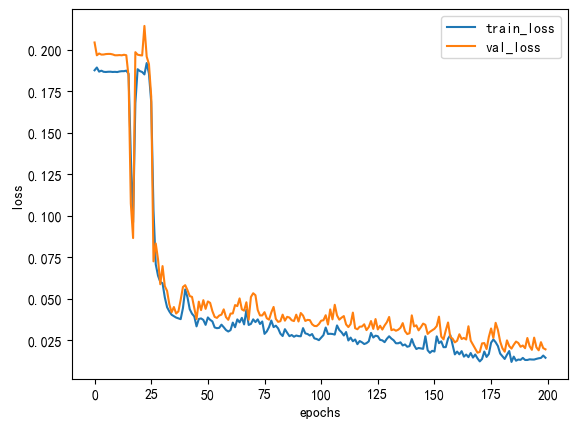

In [12]:
# 查看训练信息
plt.figure()
plt.plot(range(epochs), train_losses, label='train_loss')
plt.plot(range(epochs), val_losses, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

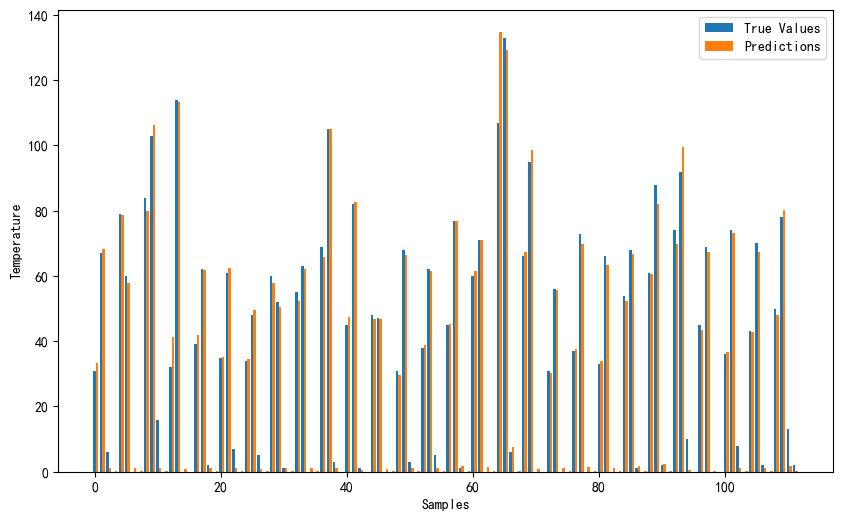

In [13]:
# 将测试集中的真实值和模型输出的预测值转换为numpy数组
y_test_true = np.array(y_test)
y_test_pred = np.array(predictions)

# 绘制柱状对比图
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(y_test_true)), y_test_true * max, width=0.4, label='True Values')
plt.bar(np.arange(len(y_test_pred)) + 0.4, y_test_pred * max, width=0.4, label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [14]:
# 如果模型在GPU上，需要先将模型参数转移到CPU上再保存
#model.to('cpu')

# 选择保存模型的路径和文件名
path = "bread_single_output.pth"

# 保存整个模型，包括模型的层、参数和其他相关信息
torch.save(model, path)